<a href="https://colab.research.google.com/github/kausar-vento/project-big-data-2023/blob/main/src/source_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=71071140a873ad8958debddddd5e955151cd5a9f14c0fab246dd0b7bfe6e4a26
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


+-----+------------------+
|tahun|total_pengangguran|
+-----+------------------+
| 2011|            123029|
| 2012|             93375|
| 2013|             97922|
| 2014|             94436|
| 2015|            149859|
| 2017|            172412|
| 2018|            157991|
| 2019|            158958|
| 2020|            212435|
| 2021|            197147|
| 2022|            206839|
+-----+------------------+



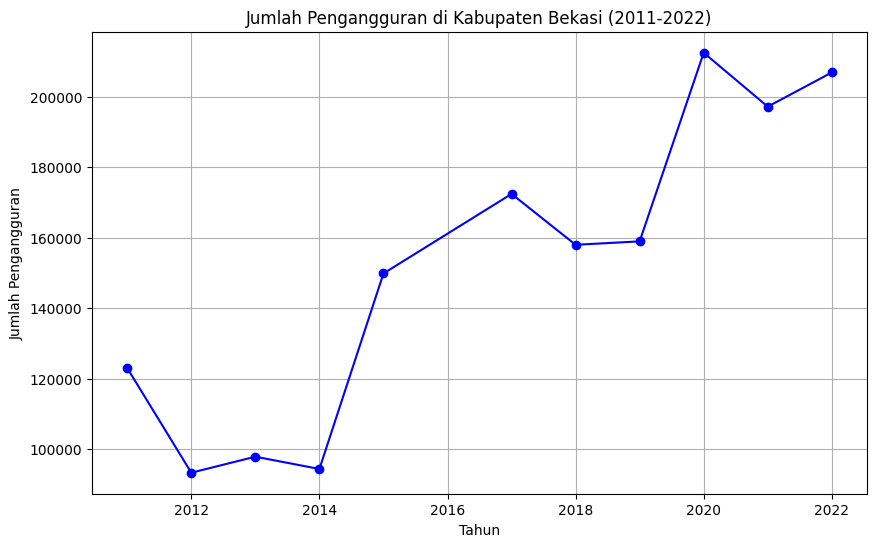

In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Inisialisasi sesi Spark
spark = SparkSession.builder.appName('UnemploymentVisualization').getOrCreate()

# Import dataset pengangguran
df = spark.read.csv('/content/drive/MyDrive/Kuliah/Semester 6/Big Data/data.csv', header=True, inferSchema=True)

# Filter dataset untuk Kabupaten Bekasi
df_bekasi = df.filter(df.nama_kabupaten_kota == 'KABUPATEN BEKASI')

# Grup berdasarkan Kabupaten Bekasi dan menghitung jumlahnya
df_bekasi_grouped = df_bekasi.groupBy('tahun').sum('jumlah_pengangguran').withColumnRenamed('sum(jumlah_pengangguran)', 'total_pengangguran')

# Urutkan tabel hasil berdasarkan tahun secara menaik
df_bekasi_grouped = df_bekasi_grouped.orderBy('tahun')

# Tampilkan tabel hasil jumlah pengangguran
df_bekasi_grouped.show()

# Visualisasi hasil pengangguran dari tahun 2011 hingga 2022
tahun = df_bekasi_grouped.select('tahun').rdd.flatMap(lambda x: x).collect()
total_pengangguran = df_bekasi_grouped.select('total_pengangguran').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.plot(tahun, total_pengangguran, color='blue', marker='o')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Pengangguran')
plt.title('Jumlah Pengangguran di Kabupaten Bekasi (2011-2022)')
plt.grid(True)
plt.show()

+-----+-------------------+
|tahun|persentase_kenaikan|
+-----+-------------------+
| 2023|  6.228348687941687|
| 2024| 11.352666278695342|
| 2025| 16.476983869448997|
| 2026| 21.601301460200855|
| 2027| 26.725619050954506|
+-----+-------------------+

Mean Squared Error (MSE): 334402582.3474988
R-squared: 0.8133961787632602


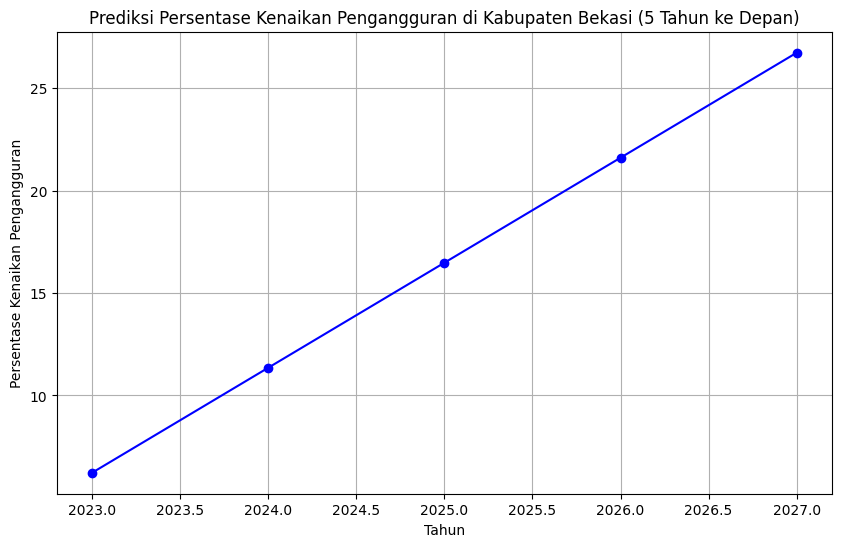

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt

# Inisialisasi sesi Spark
spark = SparkSession.builder.appName('UnemploymentPrediction').getOrCreate()

# Import dataset pengangguran
df = spark.read.csv('/content/drive/MyDrive/Kuliah/Semester 6/Big Data/data.csv', header=True, inferSchema=True)

# Filter dataset untuk Kabupaten Bekasi
df_bekasi = df.filter(df.nama_kabupaten_kota == 'KABUPATEN BEKASI')

# Grup berdasarkan Kabupaten Bekasi dan menghitung jumlahnya
df_bekasi_grouped = df_bekasi.groupBy('tahun').sum('jumlah_pengangguran').withColumnRenamed('sum(jumlah_pengangguran)', 'total_pengangguran')

# Menambahkan data 10 tahun sebelumnya (2011-2022)
df_10_years = df_bekasi_grouped.filter(df_bekasi_grouped.tahun.between(2011, 2022))

# Preprocessing dataset
assembler = VectorAssembler(inputCols=['tahun'], outputCol='features')
df_10_years = assembler.transform(df_10_years)

# Membangun model regresi linear
lr = LinearRegression(featuresCol='features', labelCol='total_pengangguran')
model = lr.fit(df_10_years)

# Prediksi jumlah pengangguran 5 tahun ke depan di Kabupaten Bekasi
tahun_terakhir = df_10_years.agg({"tahun": "max"}).collect()[0][0]
tahun_prediksi = [(tahun_terakhir + i) for i in range(1, 6)]
future_data = spark.createDataFrame([(tahun,) for tahun in tahun_prediksi], ['tahun'])
future_data = assembler.transform(future_data)
future_predictions = model.transform(future_data)

# Menghitung persentase kenaikan pengangguran
total_pengangguran_terakhir = df_10_years.orderBy('tahun', ascending=False).first()['total_pengangguran']
future_predictions = future_predictions.withColumn('persentase_kenaikan', (future_predictions['prediction'] - total_pengangguran_terakhir) / total_pengangguran_terakhir * 100)

# Menampilkan prediksi persentase kenaikan pengangguran 5 tahun ke depan di Kabupaten Bekasi
future_predictions.select('tahun', 'persentase_kenaikan').show()

# Menghitung akurasi prediksi
summary = model.summary
mse = summary.meanSquaredError
r2 = summary.r2
print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)

# Visualisasi prediksi
tahun_prediksi = future_predictions.select('tahun').rdd.flatMap(lambda x: x).collect()
persentase_kenaikan = future_predictions.select('persentase_kenaikan').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.plot(tahun_prediksi, persentase_kenaikan, color='blue', marker='o')
plt.xlabel('Tahun')
plt.ylabel('Persentase Kenaikan Pengangguran')
plt.title('Prediksi Persentase Kenaikan Pengangguran di Kabupaten Bekasi (5 Tahun ke Depan)')
plt.grid(True)
plt.show()